In [9]:
# imports and basic notebook setup
from cStringIO import StringIO
import numpy as np
import os, re
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format

import caffe

def blur(img, sigma):
    if sigma > 0:
        img[0] = nd.filters.gaussian_filter(img[0], sigma, order=0)
        img[1] = nd.filters.gaussian_filter(img[1], sigma, order=0)
        img[2] = nd.filters.gaussian_filter(img[2], sigma, order=0)
    return img

def showarray(a, fmt='png'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [2]:
def make_step(net, step_size=1.5, end='inception_4c/output', jitter=32, clip=True, focus=None):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] # input image is storred in Net's 'data' blob
    dst = net.blobs[end]
    
    # apply jitter shift
    ox, oy = np.random.randint(-jitter, jitter+1, 2) # use uniform distribution
#     ox, oy = np.random.normal(0, max(1, jitter), 2).astype(int) # use gaussian distribution
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2)
    
    # add some noise
#     src.data[0] += np.random.normal(0, 1, (3, 224, 224))
            
    net.forward(end=end)
    
    if focus is None:
        dst.diff[:] = dst.data  # specify the optimization objective
    else:
        one_hot = np.zeros_like(dst.data)
        one_hot.flat[focus] = 1.
        dst.diff[:] = one_hot
    net.backward(start=end)
    g = src.diff[0]
    
    src.data[:] += step_size/np.abs(g).mean() * g # apply normalized ascent step to the input image
    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) # unshift image
            
    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias)

In [3]:
def deepdream(net, base_img, iter_n=10, octave_n=4, octave_scale=1.4,
              start_jitter=32., end_jitter=16.,
              start_step_size=3., end_step_size=1.5,
              start_sigma=3., end_sigma=1.,
              visualize=True, focus=None,
              layers=None,
              end='inception_4c/output',
              clip=True, **step_params):    
    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]
    for i in xrange(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
    
    src = net.blobs['data']
    detail = np.zeros_like(octaves[-1]) # allocate image for network-produced details
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            # upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1)
                
        layer = end
        if layers:
            layer = layers[octave % len(layers)]

        src.reshape(1,3,h,w) # resize the network's input image size
        src.data[0] = octave_base+detail
        for i in xrange(iter_n):
            cur_focus = focus
#             if iter_n * 3 < i * 4: # don't focus so hard after 3/4 of the way through
#                 cur_focus = None
            
            sigma = start_sigma + ((end_sigma - start_sigma) * i) / iter_n
            jitter = start_jitter + ((end_jitter - start_jitter) * i) / iter_n
            step_size = start_step_size + ((end_step_size - start_step_size) * i) / iter_n
            make_step(net, end=layer, clip=clip, jitter=jitter, focus=focus, step_size=step_size, **step_params)
            src.data[0] = blur(src.data[0], sigma)
            
            if visualize:
                vis = deprocess(net, src.data[0])
                if not clip: # adjust image contrast if clipping is disabled
                    vis = vis*(255.0/np.percentile(vis, 99.98))
                showarray(vis)
            print octave, i, end
            print 'sigma =', sigma
            print 'jitter =', jitter
            print 'step_size =', step_size
            clear_output(wait=True)
            
        # extract details produced on the current octave
        detail = src.data[0]-octave_base
    # returning the resulting image
    return deprocess(net, src.data[0])

In [4]:
model_name = 'vggf'
# model_name = 'age_net'
# model_name = 'gender_net'
# model_name = 'hybridCNN+'
# model_name = 'placesCNN+'
# model_name = 'bvlc_googlenet'
# model_name = 'flowers'
model_path = '../caffe/models/' + model_name + '/'
net_fn = model_path + 'deploy.prototxt'
param_fn = model_path + 'net.caffemodel'
mean_fn = model_path + 'mean.binaryproto'

mean = np.float32([128.0, 128.0, 128.0]) # generic mean
# mean = np.float32([104.0, 116.0, 122.0]) # ImageNet mean, training set dependent
# mean = np.float32([103.939, 116.779, 123.68]) # VGG_ILSVRC-2014
if os.path.isfile(mean_fn):
    proto_data = open(mean_fn, "rb").read()
    a = caffe.io.caffe_pb2.BlobProto.FromString(proto_data)
    mean  = caffe.io.blobproto_to_array(a)[0].mean(1).mean(1)

# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".
model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
model.force_backward = True
open('tmp.prototxt', 'w').write(str(model))

net = caffe.Classifier('tmp.prototxt', param_fn,
                       mean = mean,
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

original_w = net.blobs['data'].width
original_h = net.blobs['data'].height
print 'input is {}x{}'.format(original_w, original_h)

for end in net.blobs.keys():
    cur = net.blobs[end]
    print end + ': {}x{}x{}'.format(cur.channels, cur.width, cur.height)

input is 224x224
data: 3x224x224
conv1: 64x54x54
norm1: 64x54x54
pool1: 64x27x27
conv2: 256x27x27
norm2: 256x27x27
pool2: 256x13x13
conv3: 256x13x13
conv4: 256x13x13
conv5: 256x13x13
pool5: 256x6x6
fc6: 4096x1x1
fc7: 4096x1x1
fc8: 1000x1x1
prob: 1000x1x1


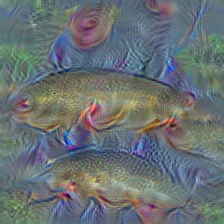

0 255 fc8
sigma = 0.109375
jitter = 4.171875
step_size = 1.505859375


In [13]:
end='fc8'
iter_n = 256
labels = range(0, 1)
for i in labels:
    frame = np.random.normal(mean, 8, (original_w, original_h, 3))
    frame = deepdream(net, frame, octave_n=1, iter_n=iter_n, end=end, focus=i,
                      start_jitter=48., end_jitter=4.,
                      start_step_size=3.0, end_step_size=1.5,
                      start_sigma=2.5, end_sigma=.1,
                      visualize=True)
#                       visualize=False)
    end_fn = re.sub('[^\w\-_\. ]', '_', end)
    img_fn = ' '.join([model_name, end_fn, '%04d'%i, str(iter_n)+'i.png'])
    PIL.Image.fromarray(np.uint8(frame)).save('frames/' + img_fn)

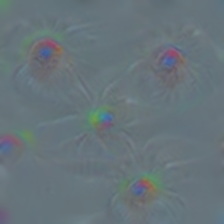

0 24 pool5
sigma = 1.08
jitter = 16.64
step_size = 1.56


In [12]:
iter_n = 25
# for i, end in enumerate(net.blobs.keys()[1:]):
for i, end in enumerate(['pool1', 'pool2', 'pool5']):
    if not 'split' in end:
        frame = np.random.normal(mean, 8, (original_w, original_h, 3))
        frame = deepdream(net, frame, octave_n=1, iter_n=iter_n, end=end)
        end_fn = re.sub('[^\w\-_\. ]', '_', end)
        img_fn = ' '.join([model_name, '%04d'%i, end_fn , str(iter_n) + 'i.png'])
        PIL.Image.fromarray(np.uint8(frame)).save('frames/' + img_fn)

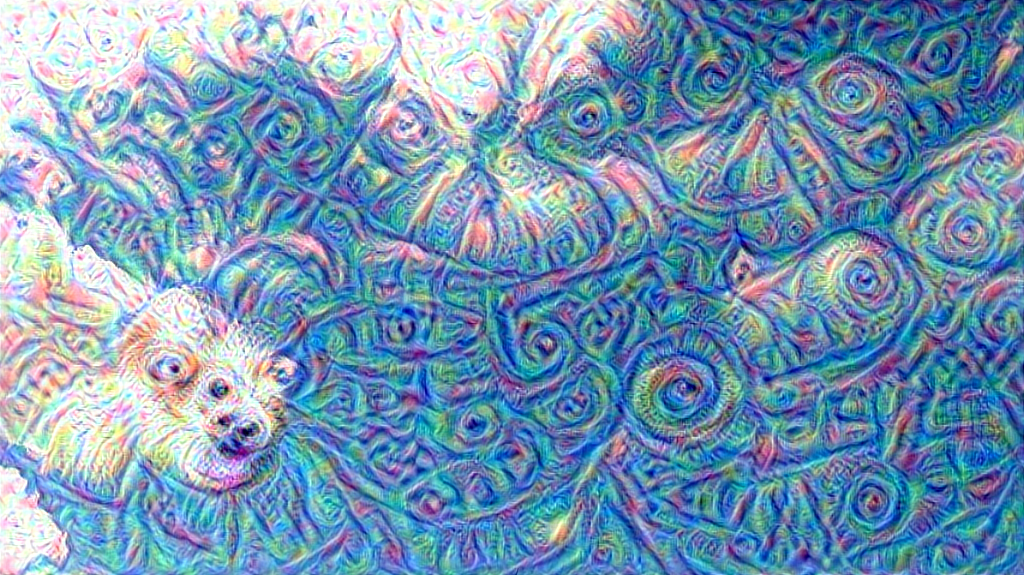

In [11]:
# googlenet
# layers = ['inception_5b/output', 'inception_5a/output', 'inception_4e/output', 'inception_4d/output', 'inception_4c/output', 'inception_4b/output', 'inception_4a/output', 'inception_3b/output', 'inception_3a/output']
# alexnet
layers = ['pool5', 'pool2', 'pool1']
# layers = ['pool5', 'conv5', 'conv4', 'conv3', 'norm2', 'pool2', 'conv2', 'norm1', 'pool1', 'conv1']

img = np.float32(PIL.Image.open('sky1024px.jpg'))
img = deepdream(net, img, iter_n=10,
          start_jitter=32., end_jitter=16.,
          start_step_size=1.5, end_step_size=1.,
          start_sigma=0., end_sigma=0.,
          layers=layers, octave_n=3*len(layers), octave_scale=1.2,
          end='inception_4c/output')
showarray(img)